<a href="https://colab.research.google.com/github/onghengkiat/KangarooSimulator/blob/master/VoiceRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Package Management

1.   soundfile 
2.   librosa
3.   glob
4.   os
5.   pickle
6.   numpy
7.   pyplot
8.   pandas
9.   seaborn
10.  sklearn



In [ ]:
#install the soundfile package that is initially not existed on google colab
!pip install soundfile

#used to extract the features from the sound file
import librosa
import soundfile

#to retrieve files that match the certain pattern like the regular expression
import glob
import os

#a useful tool to store large number of data and manage it
import numpy as np

#to save to and load model from the file
import pickle

#import my google drive so that I can save or load the model from my google drive
#and also easy access to the sample data from the drive, else the dataset is quite large to be uploaded to gooogle colab
from google.colab import drive

#mount my google drive
drive.mount('/content/drive')

#packages used for plotting graph, evaluation metrics and processing data
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

#packages used to split the data into train and test sets, create a MLP classfier model
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

#package used to evaluate the accuracy of the model
from sklearn.metrics import accuracy_score

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Data Processing

1.   Extract feature from the data
2.   Load the data from sound files



In [ ]:
#DataFlair - Extract features (mfcc, chroma, mel) from a sound file
def extract_feature(file_name, mfcc, chroma, mel):

  #reading the sound file
  with soundfile.SoundFile(file_name) as sound_file:

    #read the sound file as a numpy of numbers 
    X = sound_file.read(dtype="float32")
    
    #extract the sample rate of the sound file
    sample_rate=sound_file.samplerate
    
    #create an empty numpy array to store the result that are produced from the following 3 features
    result=np.array([])

    #if mfcc is True, then extract the mfcc features
    if mfcc:
      #calculate the mean of each column of the mfcc extracted by using the sound file and sample_rate as the parameters
      #n_mfcc determines the number of mfcc features to be extracted, in this case, it is 40
      mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)

      #then stack the 40 features extracted on the result numpy
      result=np.hstack((result, mfccs))

    #if chroma is True, then extract the chroma features
    if chroma:
      #get the stft and obtain its magnitude only, by making it positive
      stft=np.abs(librosa.stft(X))

      #calculate the mean of each column of the chroma extracted by using the stft and sample_rate
      chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)

      #then stack the chroma features extracted on the result numpy
      result=np.hstack((result, chroma))

    #if mel is True, then extract the mel features
    if mel:
      #get the melspectrogram and calculate the mean of each column as the mel value
      mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)

      #then stack the mel values on the result numpy
      result=np.hstack((result, mel))
  return result

In [ ]:
#DataFlair - Load the data and extract features for each sound file
def load_data(test_size=0.2):
    #create empty lists as the x features input and y actual output
    x,y=[],[]

    #recursively retrieve the file that matches the specific pattern in the path
    for file in glob.glob("/content/drive/My Drive/speech-emotion-recognition-ravdess-data/Actor_*/*.wav"):
        
        #get the file name of the file
        file_name=os.path.basename(file)

        #extract the emotion label from the file name
        #-1 so that the first class label will be started from 0
        #this could enable an easier interpretation in the future 
        emotion=int(file_name.split("-")[2]) - 1

        #extract the feature
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)

        #append the feature and emotion of this data into x and y which will be further analyzed later 
        x.append(feature)
        y.append(emotion)

    #split the data into test set and train set
    #by default 80% train set and 20% test set
    #we are not splitting validation data in this case as the size of the data set is too small
    #probably if we split it more, the model would be overfitting faster
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=1)
    return x_train,x_test,y_train,y_test


In [ ]:
#load the extracted features from the data
x_train,x_test,y_train,y_test= load_data()

#Model Management

1.   Tune Parameters
2.   Train Model
3.   Save Model
4.   Load Model



In [ ]:
def buildModel(x_train, y_train, network_size, alpha_value, epoch_count, layer2= False, network2_size=0):
  #Build a MLPClassifier model with 2 hidden layers
  if layer2 == True:
    #The model is built using alpha_value as the regularization term, 256 as the batch size,
    #2 hidden layers that the 1st hidden layer contains network_size +1(bias) nodes
    #the 2nd hidden layer contains network2_size + 1(bias) nodes
    #uses the adaptive learning rate so that if the loss is not decreasing significantly, then
    #the learning rate would be decreased to prevent it from oscillating around the minima so that it can converge better
    model=MLPClassifier(alpha=alpha_value, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(network_size,network2_size),
                        learning_rate='adaptive', max_iter=500)
  #Build a MLPClassifier model with only 1 hidden layer
  else:  
    #Its the same with 2 hidden layers, just a minor change on the hidden_layer_sizes parameter
    model=MLPClassifier(alpha=alpha_value, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(network_size,), 
                        learning_rate='adaptive', max_iter=500)
  model.fit(x_train,y_train)
  return model

In [ ]:
def getBestParameter(x_train,y_train,x_cv,y_cv):
  bestNetworkSize1 = 0
  bestNetworkSize2 =0
  bestAccuracy = 0
  bestModel = 0 
  bestAlpha = 0

  #the magnitude for the parameters to be tested
  alpha = (0.0001,0.0003,0.001,0.003,0.01,0.03)
  network1_size =(100,200,300,400,500)
  network2_size = (10,30,50,70,90)
  
  count = 0 
  #Tuning on the network size using 1 hidden layer only
  for alp in alpha:
    for size in network1_size:
      #run 5 times so that the tuning process is more accurate as the intial weight is also randomize
      for i in range(5):
        count+=1
        print(count)
        #build the model using size as the number of nodes on 1st hidden layer
        #300 is the maximum number of iterations being run
        #using alp as the regularization parameter
        model = buildModel(x_train,y_train,size,alp,300)

        #got the prediction from the model on cross validation set
        y_predict = model.predict(x_cv)

        #uses the prediction to compare with the actual value to calculate the accuracy of the model on validation set
        accuracy = accuracy_score(y_true = y_cv , y_pred = y_predict)
        print(accuracy)
        #if the accuracy is higher than the current best accuracy we get before using other parameter
        #then replace all the best parameters to the current parameters
        if accuracy > bestAccuracy:
          #the best parameters are printed out in case the cell has to be terminated during running
          #because it is quite a long process to run on everything
          print("one layer parameters:")
          print("first hidden layer size: ",size)
          print("alpha value: ",alp)
          bestAccuracy = accuracy
          bestNetworkSize1 = size
          bestModel = model
          bestAlpha = alp
          print("Accuracy: ",bestAccuracy)
        

  #Tuning on the network sizes using 2 hidden layers
  for alp in alpha:
    for size in network1_size:
      for size2 in network2_size:
        #run 5 times so that the tuning process is more accurate as the intial weight is also randomize
        for i in range(5):
          count+=1
          print(count)
          #build the model using size as the number of nodes on 1st hidden layer
          #uses size2 as the number of nodes on 2nd hidden layer
          #layer2 = True determines that there are 2 hidden layers
          #300 is the maximum number of iterations being run
          #using alp as the regularization parameter
          model = buildModel(x_train,y_train,size,alp,300,layer2=True,network2_size = network_size2)

          #got the prediction from the model on cross validation set
          y_predict = model.predict(x_cv)

          #uses the prediction to compare with the actual value to calculate the accuracy of the model on validation set
          accuracy = accuracy_score(y_true = y_cv , y_pred = y_predict)
          print(accuracy)
          #if the accuracy is higher than the current best accuracy we get before using other parameter
          #then replace all the best parameters to the current parameters
          if accuracy > bestAccuracy:
            #the best parameters are printed out in case the cell has to be terminated during running
            #because it is quite a long process to run on everything
            print("two layer parameters:")
            print("first hidden layer size: ",size)
            print("second hidden layer size: ",size2)
            print("alpha value: ",alp)
            bestAccuracy = accuracy
            bestNetworkSize1 = size
            bestNetworkSize2 = size2
            bestModel = model
            bestAlpha = alp
            print("Accuracy",bestAccuracy)

  return bestModel,bestAccuracy,bestNetworkSize1, bestNetworkSize2,bestAlpha

In [ ]:
#because of the dataset is too small, so we are forced to use the x_test and y_test as the validation data
#else the data is too less for the model to fit and difficult to reach a good result
model, accuracy, network_size1,network_size2, alpha = getBestParameter(x_train,y_train,x_test,y_test)

In [ ]:
#tune the best initial weight
best_model = 0
best_accuracy = 0
network_size1 = 390
network_size2 = 70
alpha = 0.01
#build the model for 50 times, every time the model is built, random initialized weight would be used
for i in range (50):

  #build the model using the best parameters tune from the method above
  #if got 2 hidden layers
  if network_size2 > 0:
    model = buildModel(x_train,y_train,network_size1,alpha,300, layer2 = True,network2_size = network_size2)

  #if only 1 hidden layer
  else :
    model = buildModel(x_train,y_train,network_size1,alpha,300)

  #calculate the accuracy on train set
  y_train_predict = model.predict(x_train)
  train_accuracy = accuracy_score(y_true = y_train , y_pred = y_train_predict)
  print("Accuracy of the model on train set : %.2f" % train_accuracy)

  #calculate the accuracy on test set
  y_test_predict = model.predict(x_test)
  test_accuracy = accuracy_score(y_true = y_test , y_pred = y_test_predict)
  print("Accuracy of the model on test set : %.2f" % test_accuracy)

  #if it is the best accuracy, then put it as the best_model and best_accuracy
  if test_accuracy > best_accuracy :
    best_model = model
    best_accuracy = test_accuracy

Accuracy of the model on train set : 0.83
Accuracy of the model on test set : 0.55
Accuracy of the model on train set : 0.53
Accuracy of the model on test set : 0.40
Accuracy of the model on train set : 0.53
Accuracy of the model on test set : 0.41
Accuracy of the model on train set : 0.61
Accuracy of the model on test set : 0.49
Accuracy of the model on train set : 0.61
Accuracy of the model on test set : 0.48
Accuracy of the model on train set : 0.76
Accuracy of the model on test set : 0.50
Accuracy of the model on train set : 0.79
Accuracy of the model on test set : 0.50
Accuracy of the model on train set : 0.66
Accuracy of the model on test set : 0.47
Accuracy of the model on train set : 0.61
Accuracy of the model on test set : 0.46
Accuracy of the model on train set : 0.66
Accuracy of the model on test set : 0.45
Accuracy of the model on train set : 0.68
Accuracy of the model on test set : 0.50
Accuracy of the model on train set : 0.44
Accuracy of the model on test set : 0.38
Accu

In [ ]:
def saveModel(model):
  #set the file path to save the file, and also the filename to be saved
  #the model is saved as .sav file
  filepath = '/content/drive/My Drive/voice_recognition_model.sav'

  #save the model using pickle.dump
  pickle.dump(model, open(filepath, 'wb'))


In [ ]:
def loadModel():
  #get the file path and also the filename to be loaded
  filepath = '/content/drive/My Drive/voice_recognition_model.sav'

  #load the model using pickel.load
  loaded_model = pickle.load(open(filepath, 'rb'))
  return loaded_model

In [ ]:
model = loadModel()
#calculate the accuracy on train set
y_train_predict = model.predict(x_train)
train_accuracy = accuracy_score(y_true = y_train , y_pred = y_train_predict)
print("Accuracy of the model on train set : %.2f" % train_accuracy)

#calculate the accuracy on test set
y_test_predict = model.predict(x_test)
test_accuracy = accuracy_score(y_true = y_test , y_pred = y_test_predict)
print("Accuracy of the model on test set : %.2f" % test_accuracy)

print(model.get_params)

Accuracy of the model on train set : 0.91
Accuracy of the model on test set : 0.61
<bound method BaseEstimator.get_params of MLPClassifier(activation='relu', alpha=0.01, batch_size=256, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(390, 70), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)>


#Analysis
1.   Loss Graph
2.   Accuracy Graph
3.   Confusion Matrix
4.   Summary of the Confusion Matrix:
  *   Precision
  *   Recall
  *   F1 Score




In [ ]:
def plotLossGraph(model):
  #plot the loss vs iterations graph of the train set
  plt.plot(model.loss_curve_)

  #Set the title of the graph
  plt.title('Model Loss')

  #Set the label of the y-axis of the graph
  plt.ylabel('loss')

  #Set the label of the x-axis of the graph
  plt.xlabel('iteration')

  #show the graph
  plt.show()

In [ ]:
def confusion_matrix(y_predict, y_test,emotion_labels):
  #create a 2d numpy array with dimension number of emotion_labels * number of emotion_labels
  matrix = np.zeros([len(emotion_labels),len(emotion_labels)])

  #iterate through every output that is predicted by the model on the test set
  for i in range(len(y_predict)):
    #vertical column represents the predicted output
    #horizontal row represents the actual output
    #jot it down on that row and column of the matrix 
    #notes: if the index of row and column is equal meanings that the predicted output is correct
    #thus, the diagonal of the matrix would be the number of correctly predicted output for the emotion
    matrix[y_test[i],y_predict[i]] += 1

  #calculate the accuracy, true positive, false positive, false negative and true negative
  true_positive, false_positive, false_negative = evaluate_confusion(matrix)

  #make the numpy to become a dataframe using pandas library
  #matrix is used as the data to build the dataframe
  #index is the row labels for the dataframe while columns is the column labels for the dataframe
  #both of them are set to be the string in the emotion_labels
  dataframe = pd.DataFrame(matrix, index = [i for i in emotion_labels],columns = [i for i in emotion_labels])

  #create a new figure and set the figure size as 10 inches as width and 7 inches as height
  plt.figure(figsize = (10,7))
  
  #uses seaborn library to create and plot the table as a heatmap by using the dataframe
  #annot = True so that value on each cell is written on the heatmap
  sn.heatmap(dataframe, annot=True)

  #Set the title of the confusion matrix
  plt.title('Confusion Matrix')

  plt.ylabel('True label')
  plt.xlabel('Predicted label')

  #show the confusion matrix
  plt.show()

  #get the summary of that can be interpreted from this matrix which are f1_score,precision and recall
  summary(true_positive, false_positive, false_negative)


In [ ]:
def evaluate_confusion(matrix):
  #create a numpy that stores the number of true positive for each class
  true_positive = np.zeros(matrix.shape[0])

  #iterate through every row in the matrix 
  for i in range(matrix.shape[0]):
    #when row and column are equal, it means the true positive cases, so add it into true_positive numpy
    true_positive[i] = matrix[i,i]
  
  #create the false positive by summing up each row
  false_positive = np.sum(matrix,axis = 0) - true_positive
  
  #calculate the false negative by summing up each column
  false_negative = np.sum(matrix,axis = 1) - true_positive

  #calculate true negative 
  true_negative = np.sum(matrix) - true_positive - false_positive - false_negative

  return true_positive, false_positive, false_negative
  

In [ ]:
def plotAccuracyBar(y_predict,y_test,emotion_labels):
  #create a numpy that represents accuracy for each emotion label
  #noted: it is firstly used to represent the number of correctly predicted output for each label
  #then after that divided by the total number of each label in the test set
  accuracy = np.zeros(len(emotion_labels))

  #create a numpy that represents total number of each emotion label in the test set
  numOfEachLabel = np.zeros(8)

  #iterate through all the outputs
  for i in range(len(y_predict)):
    #if the output is predicted correctly as the test set
    if(y_predict[i] == y_test[i]):
      #then record it in the accuracy numpy array
      accuracy[y_test[i]] += 1
    #For each iteration, increment the number of the label in the numOfEachLabel numpy array also
    numOfEachLabel[y_test[i]] += 1

  #calculate the accuracy of each label and assign it to the accuracy numpy array
  accuracy = accuracy/numOfEachLabel*100
  
  #Set the title of the bar
  plt.title('Accuracy Bar')
    
  #plot the bar graph using emotion_labels as x-axis and accuracy as the y-axis
  #makes it to be a horizontal bar so that the labels can be clearly seen
  plt.barh(emotion_labels,accuracy)

  #label the y-axis of the graph as "Emotion"
  plt.ylabel("Emotion")   

  #label the x-axis of the graph as "Accuracy in %"
  plt.xlabel("Accuracy in %")

  #show the graph"
  plt.show()


In [ ]:
def getPrecision(true_positive, false_positive): 

  #calculate the precision = true_positive / (true positive + false positive)
  precision = true_positive / (true_positive + false_positive)
  return precision
    

In [ ]:
def getRecall(true_positive, false_negative):

  #calculate the recall = true_positive / (true positive + false negative)
  recall = true_positive / (true_positive + false_negative)
  return recall

In [ ]:
def getF1_score(precision, recall):
    #calcula the f1 score using the formula
    score = 2*precision*recall/ (precision + recall)
    return score


In [ ]:
def summary(true_positive, false_positive, false_negative):
  #get the precision,recall and f1_score value
  precision = getPrecision(true_positive, false_positive)
  recall = getRecall(true_positive, false_negative)
  f1_score = getF1_score(precision,recall)

  #concatenate them into summary numpy array by column
  summary = np.vstack((precision,recall))
  summary = np.vstack((summary,f1_score))

  #make it into dataframe, column labels are emotion_labels
  #row labels are precision,recall and f1_score
  summary_df = pd.DataFrame(summary, index = ['Precision','Recall','F1 Score'],columns = [i for i in emotion_labels])
  
  #create a new figure and set the figure size as 10 inches as width and 7 inches as height
  plt.figure(figsize = (10,7))

  #uses seaborn library to create and plot the table as a heatmap by using the summary dataframe
  #annot = True so that value on each cell is written on the heatmap
  sn.heatmap(summary_df, annot=True)

  #Set the title of the summary table
  plt.title('Summary')

  #show the summary table
  plt.show()

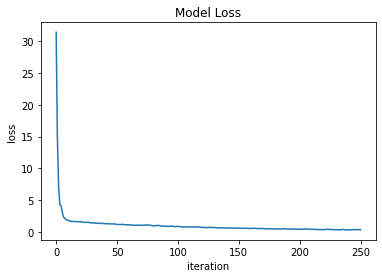

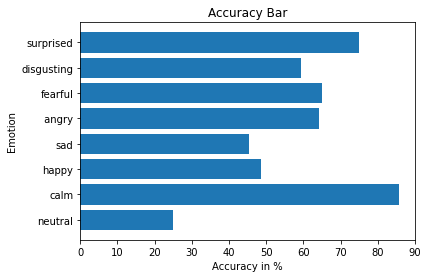

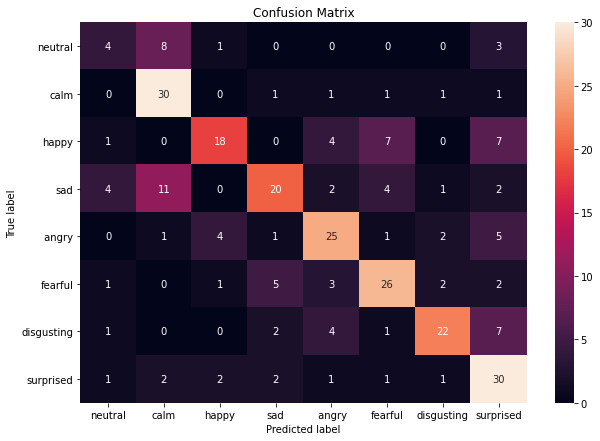

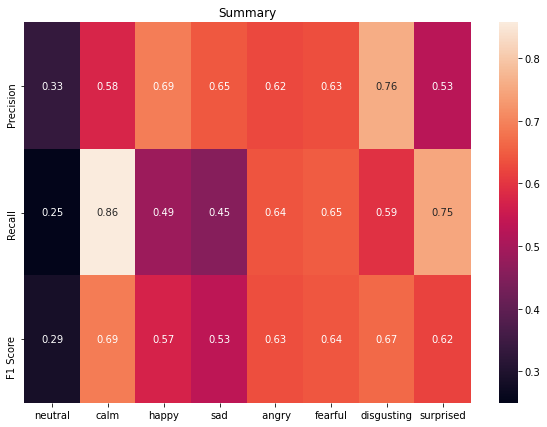

In [ ]:
#get the predicted output by the model on the test set
predictions = model.predict(x_test)

#define the emotion labels for each output class
emotion_labels = ['neutral', 'calm', 'happy', 'sad', ' angry', 'fearful', 'disgusting', 'surprised']

#plot the loss vs iteration graph
plotLossGraph(model)

#plot the accuracy bar for each label
plotAccuracyBar(predictions, y_test, emotion_labels)

#plot the confusion matrix and also the summary table of the matrix in the method
confusion_matrix(predictions,y_test,emotion_labels)
